# RNNs Tutorial with PyTorch on the IMDB Dataset

In this tutorial, we will build a Recurrent Neural Network (CNN) to classify movie reviews as positive or negative using the IMDB dataset.
 
We'll go through the following steps:

1. **Data Loading, Processing, and Augmentation**
2. **Data Exploration**
3. **Model Building**
4. **Model Training**
5. **Model Evaluation**



## 1. Data Loading, Processing, and Augmentation

The IMDB dataset contains 50,000 movie reviews, split into 25,000 reviews for training and 25,000 reviews for testing. The dataset is preprocessed, and each review is encoded as a sequence of word indexes.

### Exercise 1.1 - Data Loading and Processing

1. Load the data from `'../../data/imdb_dataset.zip'` using pandas.
2. Convert the `sentiment` column to a binary label (0 for negative and 1 for positive).
3. Split the dataset into training and test sets (25,000 samples each).
4. Preprocess the `review` column by converting it to lowercase and removing special characters, punctuation and stopwords. Additionally, use a stemming or lemmatization technique.
5. Build a vocabulary of unique words in the training dataset.
6. Tokenize the reviews using the vocabulary, i.e., replace each word with its index in the vocabulary. Note that the reviews should be padded to a fixed length.
7. Create the data loaders for training and test datasets.


In [30]:
import pandas as pd

df = pd.read_csv("/Users/tiago/dl_with_pytorch/data/imdb_dataset.zip", compression='zip')

print(df)

                                                  review sentiment
0      One of the other reviewers has mentioned that ...  positive
1      A wonderful little production. <br /><br />The...  positive
2      I thought this was a wonderful way to spend ti...  positive
3      Basically there's a family where a little boy ...  negative
4      Petter Mattei's "Love in the Time of Money" is...  positive
...                                                  ...       ...
49995  I thought this movie did a down right good job...  positive
49996  Bad plot, bad dialogue, bad acting, idiotic di...  negative
49997  I am a Catholic taught in parochial elementary...  negative
49998  I'm going to have to disagree with the previou...  negative
49999  No one expects the Star Trek movies to be high...  negative

[50000 rows x 2 columns]


In [31]:
df['sentiment'] = df['sentiment'].map({'positive': 1, 'negative': 0})
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


In [32]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=25000, stratify=df['sentiment'], random_state=42)
train.shape

(25000, 2)

In [33]:
test['sentiment'].value_counts()

sentiment
0    12500
1    12500
Name: count, dtype: int64

In [34]:
from nltk import PorterStemmer
import nltk
from nltk.corpus import stopwords
import re

nltk.download('stopwords')
nltk.download('punkt')

stop_words = set(stopwords.words('english'))

stemmer = PorterStemmer()

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    text = re.sub(r"\W+", " ", text)
    text = re.sub(r"\d+", "", text)
    tokens = [word for word in text.split()]
    words = [word for word in tokens if word not in stop_words]
    words = [stemmer.stem(word) for word in words]
    return ' '.join(words)
    
train['preproc_review'] = train['review'].apply(preprocess_text)
test['preproc_review'] = test['review'].apply(preprocess_text)

[nltk_data] Downloading package stopwords to /Users/tiago/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/tiago/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [35]:
def tokenize_text(text):
    return nltk.word_tokenize(text)

train['tokens'] = train['preproc_review'].apply(tokenize_text)
#test['tokens'] = test['preproc_review'].apply(tokenize_text)

In [36]:
top5000 = pd.Series([word for tokens in train['tokens'] for word in tokens]).value_counts().index[:5000]

top5000

Index(['br', 'movi', 'film', 'one', 'like', 'time', 'good', 'make', 'charact',
       'get',
       ...
       'spout', 'uh', 'fluff', 'razor', 'eyebrow', 'vintag', 'pornographi',
       'baron', 'feminin', 'orphan'],
      dtype='object', length=5000)

In [37]:
vocab = {word: idx + 2 for idx, word in enumerate(top5000)}
vocab ['<unk>'] = 0
vocab ['<pad>'] = 1

In [38]:
def tokens_to_idx(tokens):
    idx = []
    for token in tokens:
        i = vocab.get(token, vocab['<unk>'])
        idx.append(i)
    return idx
train['indices'] = train['tokens'].apply(tokens_to_idx) 

In [39]:
MAX_LENGTH = 300 

def pad_truncate(token, max_length = MAX_LENGTH):
    if len(token) > max_length:
        return token[:max_length]
    else: 
        return token + [vocab['<pad>']] * (max_length - len(token))
    
train['pad_trunc'] = train['indices'].apply(pad_truncate)       

In [40]:
train.head()

,review,sentiment,preproc_review,tokens,indices,pad_trunc
3055,Trio's vignettes were insightful and quite enj...,1,trio vignett insight quit enjoy curiou see man...,"[trio, vignett, insight, quit, enjoy, curiou, ...","[3435, 4510, 1546, 98, 80, 1883, 12, 46, 473, ...","[3435, 4510, 1546, 98, 80, 1883, 12, 46, 473, ..."
47326,I had never heard of this one before the owner...,0,never heard one owner local dvd rental outlet ...,"[never, heard, one, owner, local, dvd, rental,...","[51, 477, 5, 1456, 538, 181, 1904, 0, 357, 95,...","[51, 477, 5, 1456, 538, 181, 1904, 0, 357, 95,..."
48869,This is an excellent but hard to find trippy W...,1,excel hard find trippi world war spi thriller ...,"[excel, hard, find, trippi, world, war, spi, t...","[219, 168, 61, 0, 93, 186, 1857, 540, 0, 851, ...","[219, 168, 61, 0, 93, 186, 1857, 540, 0, 851, ..."
48623,"I am a huge fan of big, loud, trashy, complete...",1,huge fan big loud trashi complet stupid action...,"[huge, fan, big, loud, trashi, complet, stupid...","[535, 122, 118, 1199, 3397, 147, 261, 102, 3, ...","[535, 122, 118, 1199, 3397, 147, 261, 102, 3, ..."
39657,"Easily Lucio Fulci's most respected film, ""Don...",1,easili lucio fulci respect film tortur duckl h...,"[easili, lucio, fulci, respect, film, tortur, ...","[674, 0, 2237, 619, 4, 979, 0, 464, 0, 3476, 5...","[674, 0, 2237, 619, 4, 979, 0, 464, 0, 3476, 5..."


In [41]:
import torch
from torch.utils.data import TensorDataset, DataLoader


def prepare_data(df): 
    x = torch.tensor(df['pad_trunc'].tolist())
    y = torch.tensor(df['sentiment'].tolist())
    return TensorDataset(x, y)

train_data = prepare_data(train)

train_loader = DataLoader(train_data, batch_size = 64, shuffle = True)
test_loader = DataLoader(train_data, batch_size = 64, shuffle = True)

### Exercise 1.2 - Data Augmentation

1. Define a function to replace random words with synonyms from WordNet in the reviews.
2. Augment the training dataset by replacing words in a few reviews with synonyms.

Note: Never augment the test dataset. It's essential to evaluate the model on the original data.

In [42]:
import random
from nltk.corpus import wordnet
import nltk

nltk.download('wordnet')

def augment_text(text, max_augment=3):
    tokens = text.split()[:20]
    augmented_tokens = tokens.copy()
    
    for _ in range(max_augment):
        if len(augmented_tokens) > 1:
            rand_idx = random.randint(0, len(augmented_tokens) - 1)
            word = augmented_tokens[rand_idx]
            synonyms = wordnet.synsets(word)
            if synonyms:
                replacement = random.choice(synonyms).lemmas()[0].name()
                augmented_tokens[rand_idx] = replacement
    print(f"Original: {' '.join(tokens)}")
    print(f"Augmented: {' '.join(augmented_tokens)}")
    print('\n\n')
    return ' '.join(augmented_tokens)

# Apply augmentation to training set
train['review'].iloc[:3].apply(lambda x: augment_text(x, max_augment=3))

Original: Trio's vignettes were insightful and quite enjoyable. It was curious seeing so many soon to be famous actors when they
Augmented: Trio's vignettes were insightful and quite enjoyable. It was curious seeing indeed many soon to be famous actors when they



Original: I had never heard of this one before the owner of my local DVD rental outlet mentioned it to me;
Augmented: I receive never heard of this one earlier the owner of my local DVD rental outlet mentioned it to me;



Original: This is an excellent but hard to find trippy World War I spy thriller in the inimitable 60's Italian style.
Augmented: This is Associate_in_Nursing excellent but hard to find trippy World War I spy thriller in the inimitable 60's Italian style.



[nltk_data] Downloading package wordnet to /Users/tiago/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


3055     Trio's vignettes were insightful and quite enj...
47326    I receive never heard of this one earlier the ...
48869    This is Associate_in_Nursing excellent but har...
Name: review, dtype: object

## 2. Data Exploration

Before training our model, it's essential to explore the data. This helps us understand its distribution and visualize some examples.

### Exercise 2 - Data Exploration
1. Print the number of positive and negative reviews in the training and test datasets.
2. Plot a histogram of the length of reviews in the training and test datasets.
3. Print a few reviews and their corresponding sentiment labels.

In [43]:
train['sentiment'].value_counts()

sentiment
1    12500
0    12500
Name: count, dtype: int64

(array([1.8555e+04, 4.8840e+03, 1.1540e+03, 3.7900e+02, 2.2000e+01,
        2.0000e+00, 2.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00]),
 array([   3. ,  146.9,  290.8,  434.7,  578.6,  722.5,  866.4, 1010.3,
        1154.2, 1298.1, 1442. ]),
 <BarContainer object of 10 artists>)

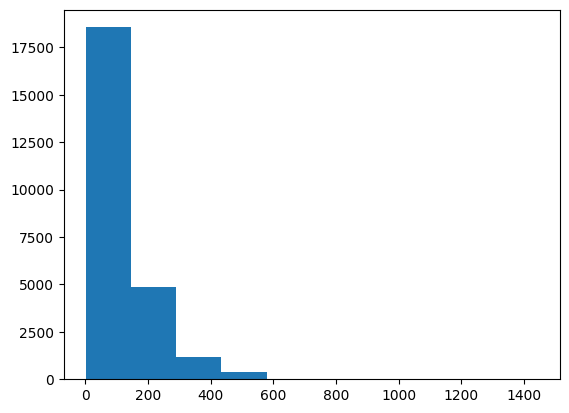

In [44]:
# length of reviews (histogram)
# length of reviews (histogram)
import matplotlib.pyplot as plt

tamanhos = train['tokens'].apply(len)
plt.hist(tamanhos, bins=10)

In [45]:
# print reviews and sentiment labels
for i in range(3):
    print(f"Review: {train['review'].iloc[i]}\nSentiment: {train['sentiment'].iloc[i]}")

Review: Trio's vignettes were insightful and quite enjoyable. It was curious seeing so many soon to be famous actors when they were very young. The performances and attention to detail were wonderful to watch.<br /><br />Observation. In film it isn't necessary that source material be in alignment with the contemporary era to be interesting or worthwhile. "Small morality" storytelling is quaint (or coy) only in the eye of the beholder--thankfully. Story content--well told--can overcome it's time, subject or place.<br /><br />Ironically, there are quite a few contemporary films today that have not overcome the conventions or cutting edge mores of the present era. Inserting "small morality" content--occasionally--might provide a dimension lacking.
Sentiment: 1
Review: I had never heard of this one before the owner of my local DVD rental outlet mentioned it to me; being a 1980s horror flick with the notorious distinction of having been banned in the U.K., I decided to check it out. The fil

## 3. Model Building

Now, we'll define our RNN architecture. A typical RNN consists of an embedding layer, RNN layers, and a fully connected layers.

### Exercise
1. Define a RNN class inheriting from torch.nn.Module.
2. Include one Embedding layer, two LSTM layers, and two Linear layers.

In [46]:
import torch.nn as nn

class RecurrentModel(nn.Module):
    
    def __init__(self, input_size, hidden_size):
        super(RecurrentModel, self).__init__()
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.lstm1 = nn.LSTM(hidden_size, int(hidden_size/2), batch_first=True)
        self.lstm2 = nn.LSTM(int(hidden_size/2), int(int(hidden_size/2)/2), batch_first=True)
        self.fc1 = nn.Linear(int(int(hidden_size/2)/2), 1)
        self.activation = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = self.embedding(x)
        x, _ = self.lstm1(x)
        x = self.activation(x)
        x, (h_n, c_n) = self.lstm2(x)
        x = self.fc1(h_n[-1])
        x = self.sigmoid(x)
        return x

## 4. Model Training

We'll now define the training loop to optimize our model using the binary cross-entropy loss function and the Adam optimizer.

### Exercise
1. Define a function to train the model for a specified number of epochs.
2. Print the training loss after each epoch.

In [25]:
from torch.nn import BCELoss
from torch.optim import Adam

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = RecurrentModel(input_size = len(vocab), hidden_size = 300).to(device)

criterion = nn.BCELoss()
optimizer = Adam(model.parameters(), lr = 0.001)

def train(model, train_loader, criterion, optimizer, epochs):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0 
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            outputs = model(x)
            loss = criterion(outputs.squeeze(), y.float())
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            predicted = (outputs.squeeze() > 0.5).long()
            correct += (predicted == y).sum().item()
            total += y.size(0)
            
        avg_loss = running_loss / len(train_loader)
        acurracy = 100. * correct / total
        print(f"Epoch: {epoch}, Loss: {avg_loss:.4f}, Accuracy: {acurracy:.2f}")
        
train(model, train_loader, criterion, optimizer, epochs=5)
            

Epoch: 0, Loss: 0.6933, Accuracy: 50.39
Epoch: 1, Loss: 0.6091, Accuracy: 67.39
Epoch: 2, Loss: 0.4656, Accuracy: 79.86
Epoch: 3, Loss: 0.3585, Accuracy: 85.52
Epoch: 4, Loss: 0.3027, Accuracy: 88.01


## 5. Model Evaluation

After training, we need to evaluate our model on the test dataset to understand its performance.

### Exercise
1. Define a function to evaluate the model's accuracy on the test set.
2. Print the accuracy.

In [48]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        outputs = model(x)
        predicted = (outputs.squeeze() > 0.5).long()
        correct += (predicted == y).sum().item()
        total += y.size(0)
        
print(f"Test Accuracy: {100*correct/total:.2f}%")



Test Accuracy: 91.45%
